In [76]:
import numpy as np 
import os 
import sys 
MAIN_PATH = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
os.chdir(MAIN_PATH)



In [77]:
AUC_loocv_1_0_path = 'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v1l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/itr_0/y_pred.npy'

AUC_loocv_1_1_path = 'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v1l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/itr_1/y_pred.npy'

AUC_loocv_1_3_path = 'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v1l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/itr_3/y_pred.npy'

AUC_loocv_2_path ='results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v2l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/y_pred.npy'

AUC_loocv_3_path = 'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v3l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/y_pred.npy'

y_true_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/allData/prognosis_mix_hb/pretreatment_response/label.npy'

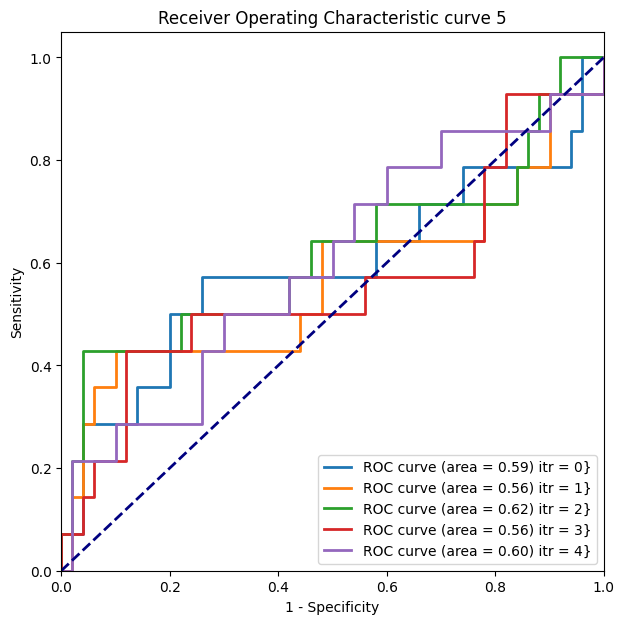

AUC for set 5: 0.5971428571428571


In [109]:

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
y_true = np.load(y_true_path)

# --- use mean first 
y_pred_paths = [AUC_loocv_1_0_path, AUC_loocv_1_1_path, AUC_loocv_1_3_path, AUC_loocv_2_path, AUC_loocv_3_path]
method = 'mean_first' # 'mean_first' or 'argmax_first'
cv_fold_method = 'together' # together or separate





    # separate the cv folds
    
if cv_fold_method == 'separate':

    for i, y_pred_path in enumerate(y_pred_paths):
    #for y_pred_path in [AUC_loocv_3_path]:
        plt.figure(figsize=(7, 7))
        y_pred_k_fold = np.load(y_pred_path)

        if 'loocv_v3' in y_pred_path: K_FOLD = 4
        else: K_FOLD = 5
        y_pred_k_fold = np.load(y_pred_path) 
        y_pred = np.reshape(y_pred_k_fold, (-1, K_FOLD, 2))
        for k in range(K_FOLD):
            y_pred_k = y_pred[:, k, :]
            # print('y_pred_k.shape', y_pred_k.shape)
            fpr, tpr, _ = roc_curve(y_true, y_pred_k[:, 1] - y_pred_k[:, 0]**2)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) k_fold: %d' % (roc_auc, k))
    
if cv_fold_method == 'together':
    plt.figure(figsize=(7, 7))
    fprs = [] # for mean AUC
    tprs = [] # for mean AUC
    roc_aucs = []
    for i, y_pred_path in enumerate(y_pred_paths):
        if 'loocv_v3' in y_pred_path: K_FOLD = 4
        else: K_FOLD = 5
        y_pred_k_fold = np.load(y_pred_path)
        # using all cv folds together
        if method == 'mean_first':
            # y_pred_k_fold[:,1] += val_offset
            y_pred = np.reshape(y_pred_k_fold, (-1, K_FOLD, 2))
            y_pred = np.mean(y_pred, axis=1)
            # auc = roc_auc_score(y_true, y_pred[:, 1])
            fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        elif method == 'argmax_first':
            y_pred = np.argmax(y_pred_k_fold, axis=1)
            y_pred = np.reshape(y_pred, (-1, K_FOLD))
            y_pred_mean = np.mean(y_pred, axis=1)
            fpr, tpr, _ = roc_curve(y_true, y_pred_mean)
        fprs.append(fpr)
        tprs.append(tpr)
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) itr = %d}' % (roc_auc, i))

        
    # ----
    


    # Plotting the ROC curve
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title(f'Receiver Operating Characteristic curve {i+1}')
    plt.legend(loc="lower right")
    plt.show()

    print(f'AUC for set {i+1}: {roc_auc}')


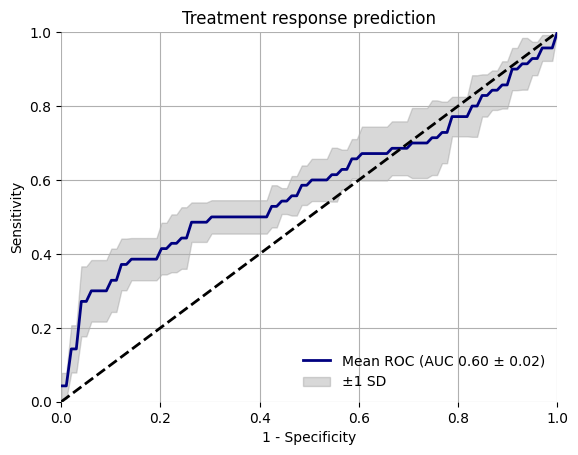

In [135]:
from scipy import interp
mean_fpr = np.linspace(0, 1, 100)

# Interpolate TPRs at these common FPR levels
mean_tpr = np.zeros_like(mean_fpr)
tpr_interpolated = []

for i in range(len(fprs)):
    tpr_interp = np.interp(mean_fpr, fprs[i], tprs[i])
    tpr_interpolated.append(tpr_interp)
    
    
# Calculate the mean TPR
tpr_interpolated = np.array(tpr_interpolated)
mean_tpr = tpr_interpolated.mean(axis=0)
std_tpr = tpr_interpolated.std(axis=0)

tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)

# Compute AUC
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(roc_aucs)
# mean_fpr = np.linspace(0, 1, 100)
# mean_tpr = np.zeros_like(mean_fpr)
# mean_tpr = np.interp(mean_fpr, fpr, tpr)
# roc_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, lw=2, color='#000080', label='Mean ROC (AUC %0.2f ± %0.2f)' % (roc_auc, std_auc))
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.3, label='±1 SD')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title(f'Treatment response prediction')
plt.legend(loc="lower right", frameon=False)

for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()



# plt.plot(mean_fpr, mean_tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)